In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [32]:
%pip install DBCV

  Could not find a version that satisfies the requirement DBCV (from versions: )
No matching distribution found for DBCV
You are using pip version 9.0.3, however version 21.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>

Using labelled data, this notebook will apply the HDBSCAN clustering algorithm and evaluate the clusters using the specified performance metrics.
### overview of algorithms and measures
http://www.warse.org/IJATCSE/static/pdf/file/ijatcse188922020.pdf

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp

# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
import hdbscan
import sklearn.utils
from sklearn import metrics
from clusteval import clusteval
import hnet

from scipy.spatial import euclidean
from DBCV import DBCV

%matplotlib inline
sns.set_context("poster")
sns.set_style("white")
sns.set_color_codes()
plot_kwds = {"alpha": 0.5, "s": 80, "linewidths": 0}

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv("../Data/100dim_labeled_synth_data.csv").drop(["Unnamed: 0"], axis=1)

<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'labels'}>]], dtype=object)

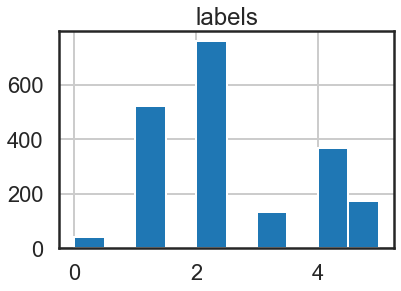

<IPython.core.display.Javascript object>

In [4]:
data["labels"] = data["labels"] - 1
# determine the number of classes and class imbalance
data.hist(column="labels")

In [5]:
X = data.iloc[:, :-1]
hdb_scan = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdb_scan.fit(X)

HDBSCAN(gen_min_span_tree=True)

<IPython.core.display.Javascript object>

# Visualization

In [6]:
# clusterer.minimum_spanning_tree_.plot(edge_cmap="viridis", edge_linewidth=2)

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='distance'>

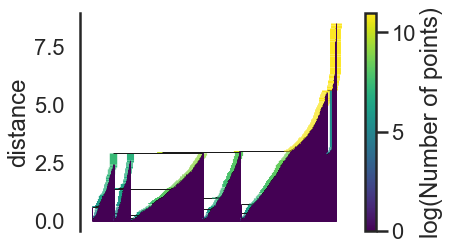

<IPython.core.display.Javascript object>

In [7]:
hdb_scan.single_linkage_tree_.plot(cmap="viridis", colorbar=True)

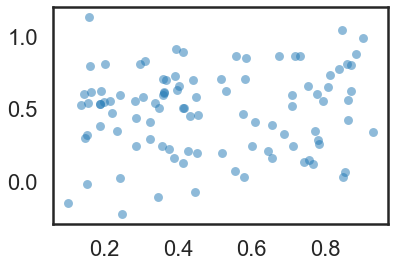

<IPython.core.display.Javascript object>

In [8]:
palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1], **plot_kwds)

In [9]:
data["labels"] = hdb_scan.labels_
hdb_scan.labels_

array([4, 5, 4, ..., 4, 2, 1])

<IPython.core.display.Javascript object>

## 3D plots

In [10]:
labels = data.pop("labels")

<IPython.core.display.Javascript object>

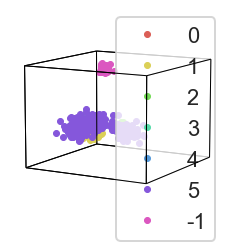

<IPython.core.display.Javascript object>

In [11]:
hyp.plot(data, ".", group=labels, legend=list(set(labels)))

### reduce with t-SNE

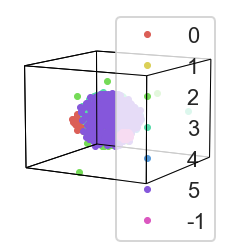

<IPython.core.display.Javascript object>

In [12]:
geo_tsne = hyp.plot(
    data, ".", group=labels, legend=list(set(labels)), reduce="TSNE", ndims=3
)

### reduce with PCA

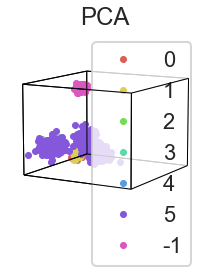

<IPython.core.display.Javascript object>

In [13]:
geo = hyp.plot(
    data, ".", group=labels, reduce="PCA", title="PCA", legend=list(set(labels))
)

# Evaluation Metrics

# https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
Gap Statistic??? <br>
Elbow Method <br>
Silhouette Coefficient <br>
Calinski-Harabasz Index <br>
Davies-Bouldin Index <br>

# https://towardsdatascience.com/evaluation-metrics-for-clustering-models-5dde821dd6cd
Purity <br>
Normalized mutual information (NMI) <br>
Rand index <br>
Adjusted Rand Index <br>
Jaccard Index <br>
Fowlkes Mallows Index <br>

In [14]:
predictions = hdb_scan.fit_predict(X)

<IPython.core.display.Javascript object>

# Gap Statistic??

In [29]:
# randomReference = np.random.random_sample(size=X.shape)  # generate reference dataset

# hdb_scan.fit(randomReference)  # fit to reference data
# refDisp = hdb_scan.inertia_  # get reference dispersion

# hdb_scan.fit(X)  # fit to original data
# origDisp = hdb_scan.inertia_  # get original dispersion

# gap = np.log(refDisp) - np.log(origDisp)  # calculate gap

<IPython.core.display.Javascript object>

# Silhouette Coefficient

In [16]:
metrics.silhouette_score(X, predictions, metric="euclidean")

0.3299877559164761

<IPython.core.display.Javascript object>

# Calinski-Harabasz Index*

In [17]:
metrics.calinski_harabasz_score(X, predictions)

212.85316158261014

<IPython.core.display.Javascript object>

# Davies-Bouldin Index*

In [18]:
metrics.davies_bouldin_score(X, predictions)

2.784177528787565

<IPython.core.display.Javascript object>

# Purity*

In [19]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


purity_score(labels, predictions)

1.0

<IPython.core.display.Javascript object>

# Normalized Mutual Information (NMI)

In [20]:
metrics.normalized_mutual_info_score(labels, predictions)

1.0

<IPython.core.display.Javascript object>

# Adjusted Rand Index

In [21]:
metrics.adjusted_rand_score(labels, predictions)

1.0

<IPython.core.display.Javascript object>

# Jaccard Index

## maunal implementation

In [23]:
# define Jaccard Similarity function
def jaccard(true, pred):
    intersection = len(list(set(true).intersection(pred)))
    union = (len(true) + len(pred)) - intersection
    return float(intersection) / union


# find Jaccard Similarity between the two sets
jaccard(labels, predictions)

0.001753067868770348

<IPython.core.display.Javascript object>

## sklearn implementation

In [25]:
metrics.jaccard_score(
    labels, predictions, average="micro"
)  # accounts for class imbalance

1.0

<IPython.core.display.Javascript object>

# Fowlkes Mallows Index

In [26]:
metrics.fowlkes_mallows_score(labels, predictions)

1.0

<IPython.core.display.Javascript object>

# DBCV

# clusteval

In [28]:
# https://stackoverflow.com/questions/57377594/how-to-evaluate-hdbscan-text-clusters

# Determine the optimal number of clusters
ce = clusteval(cluster="hdbscan")
ce.plot()
ce.scatter(X)

AttributeError: 'clusteval' object has no attribute 'results'

<IPython.core.display.Javascript object>

In [ ]:
# using hnet

# Get labels
clusterlabels = results['labx']

# Compute the enrichment of the cluster labels with the dataframe df
enrich_results = hnet.enrichment(X, clusterlabels)

# DBCV

In [ ]:
from scipy.spatial import euclidean
from DBCV import DBCV